# Data Science and Big Data Project1
## Intermediate Progress
Group 14: Honda Zhang, Jessica Zhu

**Summary:** By now, we basically finished two parts: *data collection and cleaning, finding countries sharing similar music tastes.*

**1. Data collection and cleaning**
Our current dataset has three components:
- Weekly top 200 songs from 59 countries (2017-2019): `top_songs_country.csv`
- Audio features for each song: `audio_features.csv`
- Lyrics for each song (only English songs): `lyrics.csv`

To get these datasets, we created several python files and jupyter notebooks to scrap data from Spotify API and Genius API and clean the data. We included all these files in the zip file. Below is the brief instruction of all those files:

- `top_200_songs_scrapper.py`: scraping weekly top 200 songs from 59 countries and store data from each country as a csv file separately.
- `total_rank_df.py`: read weekly top 200 songs from each country and use the total counts of each songs to re-rank songs and store the result as a csv file separtely.
- `get_track_features.py`: scraping audio features for all the songs in our dataset from Spotify API.
- `scrap_lyrics.ipynb`: scraping lyrics from Genius API.

**2. Finding countries sharing similar music tastes**
To define similarity for music taste, we tried two methods: 
- couting number of same songs in top 100 songs
- create one-hot-encoding features and clustering

To see the details of this part, please see the below cells in this notebook.

**Next Steps**:
1. Improving current methods of finding similar countries: currently we used one-hot-encoding, we might find a creative way to incorporate ranking information in the encoding part and then clustering.
2. Analysing audio features and lyrics for each group of countries: need to figure out a better way to presenting findings.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Read the data and create dataframe

In [3]:
mapping_df = pd.read_csv('region_mapping.csv', header=None)
list_of_ac = mapping_df[0].tolist()
list_of_full = mapping_df[1].tolist()
countries = list(zip(list_of_ac, list_of_full))

In [4]:
# Create a dataframe that contains all the information of 200 songs of each country
df_rank = pd.DataFrame()
for country in countries:
    file_name = 'total_rank_data/' + country[0] + '.csv'
    temp = pd.read_csv(file_name)
    famous_song_series = temp[['Track Name', 'spotify_id']][:100]
    famous_song_df = pd.DataFrame({'Name': famous_song_series['Track Name'],\
                                   'spotify_id': famous_song_series['spotify_id'],
                                   'Country': country[1]})
    df_rank = df_rank.append(famous_song_df)
df_rank.head()

,Name,spotify_id,Country
0,Crimen,3oqWr0jDWNXxWufNogGREp,Argentina
1,Creo,5Bi9Cq5oVFy1OtUgecbegZ,Argentina
2,Spaghetti del Rock,6rg1MBZqggsQ5olFGTw0rr,Argentina
3,Nunca quise,0ZAJ660VP57lLK4U7NlGOy,Argentina
4,Me Gusta,3pMo77B4r1NwwIK78lO4xf,Argentina


In [5]:
# reset the index of the dataframe
df_rank = df_rank.reset_index()
df_rank = df_rank.rename(columns = {'index':'rank'})
df_rank.head()

,rank,Name,spotify_id,Country
0,0,Crimen,3oqWr0jDWNXxWufNogGREp,Argentina
1,1,Creo,5Bi9Cq5oVFy1OtUgecbegZ,Argentina
2,2,Spaghetti del Rock,6rg1MBZqggsQ5olFGTw0rr,Argentina
3,3,Nunca quise,0ZAJ660VP57lLK4U7NlGOy,Argentina
4,4,Me Gusta,3pMo77B4r1NwwIK78lO4xf,Argentina


In [6]:
df_rank.to_csv('top_songs_country.csv')

In [7]:
country_matrix_rank = pd.DataFrame(columns=[country[1] for country in countries])

In [8]:
# create the similarity matrix based on direct similarity comparison
for country in countries:
    score_list = []
    current_temp = df_rank[df_rank['Country'] == country[1]]
    for counterparty in country_matrix_rank.iteritems():
        counterparty_temp = df_rank[df_rank['Country'] == counterparty[0]]
        # merge the table to see the percentage of similarity
        temp = counterparty_temp.merge(current_temp, left_on='Name', right_on='Name')
        score_list.append(len(temp)/len(current_temp))
    country_matrix_rank.loc[country[1]] = score_list

In [9]:
# filter country that not similar with other
# this list of countries will be eliminated from the clustering analysis to produce more meaningful clusters
unique_country = list(country_matrix_rank[country_matrix_rank.sum(axis = 1) < 7].index)
unique_country

['Brazil', 'France', 'Japan', 'Nicaragua', 'Turkey']

Create an intial graph on the similarity matrix to detect whether there is a pattern

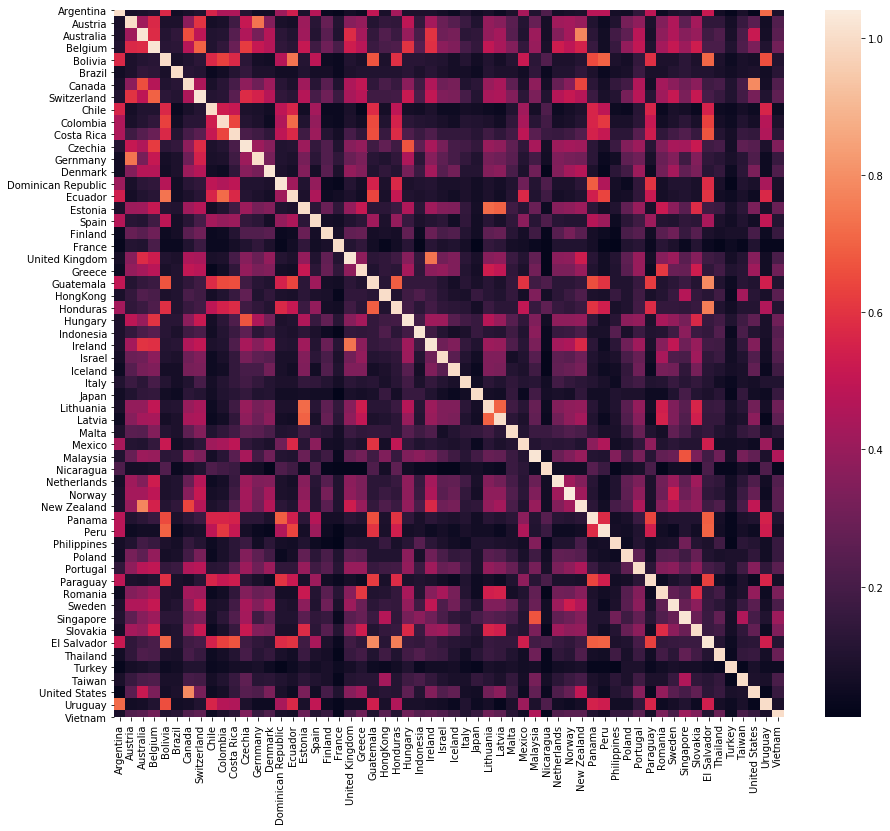

In [10]:
plt.figure(figsize = (15,13))
sns.heatmap(country_matrix_rank)

From this plot, we can see that some of the countries share similar music tastes. However, it's hard to use the result to group similar countries. Therefore, we tried to use clustering method the find the similar countries.

# Clustering

In [11]:
# first use one-hot-encoding to create features
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [12]:
ohe_features = enc.fit_transform(np.array(df_rank['Name']).reshape(-1,1)).toarray()

In [13]:
enc.categories_

[array(['#ihanaa', "'Di Na Muli", "'Till I Collapse", ..., '鱗(うろこ)',
        '빨간 맛 Red Flavor', '피카부 Peek-A-Boo'], dtype=object)]

In [14]:
df_ohe = pd.DataFrame(ohe_features)

In [15]:
df_ohe['Country'] = df_rank.reset_index()['Country']

In [16]:
# sum ohe features by country
df_ohe = df_ohe.groupby('Country').sum()

In [17]:
df_ohe.head()

,0,1,2,3,4,5,6,7,8,9,...,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130
Country,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Australia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Austria,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# incorporate ranking information into the one hot encoder
def ohe_rank(df_ohe, df_rank, enc):
    df_ohe_rank = df_ohe.copy()
    ohe_dict = {i:enc.categories_[0][i] for i in df_ohe.columns}
    for country in df_ohe.index:
        for song in df_ohe.columns:
            if df_ohe_rank.loc[country][song] == 1:
                df_ohe_rank.loc[country][song] = 100-df_rank[(df_rank['Country'] == country)&
                                                    (df_rank['Name'] == ohe_dict[song])]['rank'] 
                # use 200-rank becuase we want to give higher rank more importance
    return df_ohe_rank

In [19]:
df_ohe_rank = ohe_rank(df_ohe, df_rank, enc)

In [20]:
df_ohe_rank.head()

,0,1,2,3,4,5,6,7,8,9,...,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130
Country,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Australia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Austria,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# delete unique countries from the list to facilitate clustering
df_ohe_cluster = df_ohe_rank.copy()
df_ohe_cluster.drop(index = unique_country, inplace = True)

In [22]:
df_ohe_unique_country = df_rank[df_rank['Country'].isin(unique_country)]

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k = None
best_labels = None
best_score = -1
best_model = None

scores_kmeans = {}

for k in range(2, 21):
    
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(df_ohe_cluster)
    
    labels = kmeans.labels_
    score = silhouette_score(df_ohe_cluster, labels)
    scores_kmeans[k] = score
    print('k =', k, 'has silhouette score', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = kmeans
        best_labels = labels

print()
print("Best k = " + str(best_k), 'according to silhouette score')
print()


k = 2 has silhouette score 0.16207400835225955
k = 3 has silhouette score 0.1740694057962407
k = 4 has silhouette score 0.1363896567385324
k = 5 has silhouette score 0.1294431166772954
k = 6 has silhouette score 0.1318298387052571
k = 7 has silhouette score 0.1304298773635825
k = 8 has silhouette score 0.13335013703522916
k = 9 has silhouette score 0.05715407922624531
k = 10 has silhouette score 0.0731138815047713
k = 11 has silhouette score 0.07552114470000514
k = 12 has silhouette score 0.05366141451548496
k = 13 has silhouette score 0.07868473959696283
k = 14 has silhouette score 0.08468190418168037
k = 15 has silhouette score 0.07961073983487785
k = 16 has silhouette score 0.09574920303510971
k = 17 has silhouette score 0.08027126827307351
k = 18 has silhouette score 0.08367130842366986
k = 19 has silhouette score 0.08248111850258974
k = 20 has silhouette score 0.09256061931866331

Best k = 3 according to silhouette score



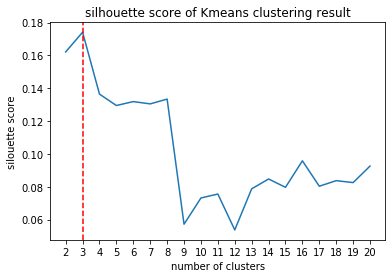

In [24]:
plt.plot(list(scores_kmeans.keys()), list(scores_kmeans.values()))
plt.axvline(x = best_k, color = 'r', linestyle = '--')
plt.xticks(list(scores_kmeans.keys()))
plt.ylabel('silouette score')
plt.xlabel('number of clusters')
plt.title('silhouette score of Kmeans clustering result')
plt.show()

In [25]:
kmeans = KMeans(n_clusters = best_k, random_state = 0)
kmeans.fit(df_ohe_cluster)
df_ohe_cluster['Cluster'] = kmeans.labels_

In [26]:
df_ohe_cluster['Cluster'].value_counts()

1    29
2    16
0     8
Name: Cluster, dtype: int64

In [27]:
cluster_3 = list(df_ohe_cluster.groupby('Cluster').get_group(0).index)
cluster_3

['HongKong',
 'Indonesia',
 'Malaysia',
 'Philippines',
 'Singapore',
 'Taiwan',
 'Thailand',
 'Vietnam']

In [28]:
cluster_1 = list(df_ohe_cluster.groupby('Cluster').get_group(1).index)
cluster_1

['Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Czechia',
 'Denmark',
 'Estonia',
 'Finland',
 'Gernmany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Israel',
 'Italy',
 'Latvia',
 'Lithuania',
 'Malta',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Sweden',
 'Switzerland',
 'United Kingdom',
 'United States']

In [29]:
cluster_2 = list(df_ohe_cluster.groupby('Cluster').get_group(2).index)
cluster_2

['Argentina',
 'Bolivia',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'Ecuador',
 'El Salvador',
 'Guatemala',
 'Honduras',
 'Mexico',
 'Panama',
 'Paraguay',
 'Peru',
 'Spain',
 'Uruguay']

In [30]:
cluster_4 = unique_country
cluster_4

['Brazil', 'France', 'Japan', 'Nicaragua', 'Turkey']

In [37]:
cluster_regions = ['South America', 'European & North America','Southeast Asia']

In [38]:
group_0 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(0).index))]
group_1 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(1).index))]
group_2 = df_rank.loc[df_rank['Country'].isin(list(df_ohe_cluster.groupby('Cluster').get_group(2).index))]

In [39]:
group_0.head()

,rank,Name,spotify_id,Country
2300,0,Shape of You,7qiZfU4dY1lWllzX7mPBI3,HongKong
2301,1,不該,7LyCtbxher5m97MImn5M3l,HongKong
2302,2,告白氣球,1ivCIgrYZyE0BvItL4Z8lk,HongKong
2303,3,Closer (feat. Halsey),7BKLCZ1jbUBVqRi2FVlTVw,HongKong
2304,4,囍帖街,0Ye5Yf1jxFArVcNwkXwUjQ,HongKong


Use clustering result to revisit the heat map

In [31]:
# create a list of country in the sequence of the cluster
final_country = cluster_2 + cluster_1 +cluster_3 + cluster_4

In [32]:
final_matrix = pd.DataFrame(columns=[country for country in final_country])

In [33]:
# recalculate the similarity matrix with label being the cluster sequence
for country in final_country:
    score_list = []
    current_temp = df_rank[df_rank['Country'] == country]
    for counterparty in final_matrix.iteritems():
        counterparty_temp = df_rank[df_rank['Country'] == counterparty[0]]
        temp = counterparty_temp.merge(current_temp, left_on='Name', right_on='Name')
        score_list.append(len(temp)/len(current_temp))
    final_matrix.loc[country] = score_list

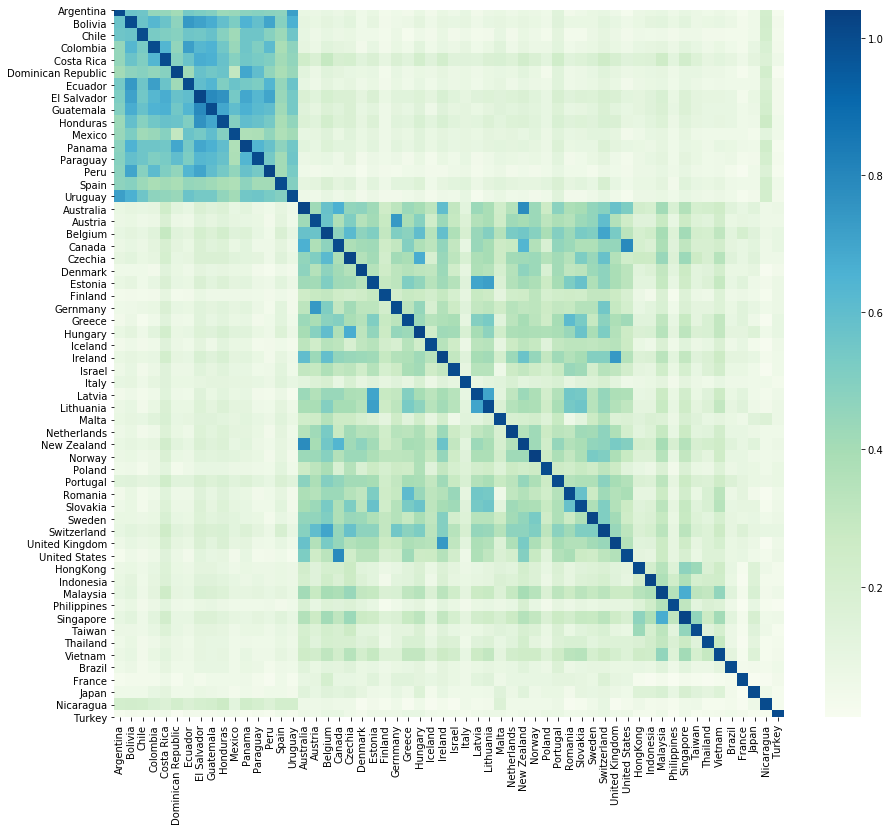

In [34]:
# print out the heatmap for the cluster result
plt.figure(figsize = (15,13))
sns.heatmap(final_matrix, cmap="GnBu")

From the heatmap, we observe the similarity between South American countries is very close. People in South America has the same tase in musicto only South American. While Europe, North America and Oceania shares a medium similar taste of music. Asian has a similar taste but they also in some degree like Europe, North American, and Oceania music.

**Visualization of clustering result**

In [36]:
import folium
import json

In [38]:
# import the definition of country
country_geo = 'world-countries.json'
with open(country_geo) as f:
    geo = json.load(f)

append country in each cluster

In [39]:
geo_color = pd.DataFrame({'Name': cluster_1, "Value":1})
geo_color = geo_color.append(pd.DataFrame({'Name': cluster_2, "Value": 2}))
geo_color = geo_color.append(pd.DataFrame({'Name': cluster_3, "Value": 3}))
geo_color = geo_color.append(pd.DataFrame({'Name': cluster_4, "Value": 4}))
geo_color = geo_color.reset_index(drop=True)
# the United States in the dataframe is in another name as "United States of America" in the
# geo file, change the name in order to get the correct visualization
geo_color.replace("United States", "United States of America", inplace=True) 

In [40]:
# Setup a folium map at a high-level zoom 
m = folium.Map(location=[0, 0], zoom_start=1.5)
# choropleth maps bind Pandas Data Frames and json geometries. 
# This allows us to quickly visualize data combinations
folium.Choropleth(geo_data=geo, data=geo_color, name="choropleth",
             columns=['Name', "Value"],
             key_on='feature.properties.name',
             fill_color='PiYG', fill_opacity=1, line_opacity=0.5).add_to(m)

Save the visualization as an HTML file, and show the visualization

In [41]:
m.save('globalmap.html')
m

From the visualization, it is obvious that except for 5 of the unique countries. The cluster is depend on the geographic continents. With South America in one cluster. North America, Europe, and Oceania in another cluster, and Asian countries in the third cluster. There are also exceptions which is Spain, which is a European country but share similar music taste as South American. Black region stands for data not available (Not major user of Spotify)

# Analysis Track Features
https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/

In [50]:
track_features = pd.read_csv('audio_features.csv')

In [51]:
track_features.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0.799,0.722,7,-5.051,1,0.0387,0.35900,0.000000,0.178,0.880,128.012,audio_features,2EhvCzRw0C7anZHsj284oX,spotify:track:2EhvCzRw0C7anZHsj284oX,https://api.spotify.com/v1/tracks/2EhvCzRw0C7a...,https://api.spotify.com/v1/audio-analysis/2Ehv...,176906,4
1,1,0.553,0.964,0,-6.710,1,0.0568,0.00221,0.017600,0.060,0.530,133.935,audio_features,6BI4NrjNsQfac2erXVjSVf,spotify:track:6BI4NrjNsQfac2erXVjSVf,https://api.spotify.com/v1/tracks/6BI4NrjNsQfa...,https://api.spotify.com/v1/audio-analysis/6BI4...,220177,4
2,2,0.668,0.816,9,-3.708,0,0.0322,0.03110,0.000025,0.195,0.550,129.975,audio_features,3CZoTwEuhvrokhej4VAo0Q,spotify:track:3CZoTwEuhvrokhej4VAo0Q,https://api.spotify.com/v1/tracks/3CZoTwEuhvro...,https://api.spotify.com/v1/audio-analysis/3CZo...,253027,4
3,3,0.547,0.881,4,-5.994,0,0.3100,0.11100,0.000000,0.386,0.440,86.628,audio_features,7CbkW1lLxOM5D6YWTnzknv,spotify:track:7CbkW1lLxOM5D6YWTnzknv,https://api.spotify.com/v1/tracks/7CbkW1lLxOM5...,https://api.spotify.com/v1/audio-analysis/7Cbk...,166486,4
4,4,0.639,0.745,0,-3.631,1,0.0416,0.11000,0.000000,0.131,0.356,139.993,audio_features,4ffYbqNOSn01NHOmQGJEKT,spotify:track:4ffYbqNOSn01NHOmQGJEKT,https://api.spotify.com/v1/tracks/4ffYbqNOSn01...,https://api.spotify.com/v1/audio-analysis/4ffY...,193948,4


In [52]:
# merge country rank dataframe with audio features
group_0_audio = pd.merge(group_0, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')
group_1_audio = pd.merge(group_1, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')
group_2_audio = pd.merge(group_2, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')
unique_country_audio = pd.merge(df_ohe_unique_country, track_features, how = 'left', left_on = 'spotify_id', right_on = 'id')

In [53]:
hist_columns = list(track_features.columns[:12]) + list(track_features.columns[-2:-1])
hist_columns.remove('mode')
hist_columns.remove('Unnamed: 0')
hist_columns.remove('key')

In [54]:
radar_list = hist_columns
radar_list.remove('loudness')
radar_list.remove('tempo')
radar_list.remove('duration_ms')

In [55]:
a = pd.DataFrame(columns = hist_columns)
a = a.append({key:value for key,value in zip(group_0_audio[radar_list].mean().index, 
                                list(group_0_audio.groupby('spotify_id').max()[radar_list].mean()))},ignore_index=True)
a = a.append({key:value for key,value in zip(group_1_audio[radar_list].mean().index, 
                                list(group_1_audio.groupby('spotify_id').max()[radar_list].mean()))},ignore_index=True)
a = a.append({key:value for key,value in zip(group_2_audio[radar_list].mean().index, 
                                list(group_2_audio.groupby('spotify_id').max()[radar_list].mean()))},ignore_index=True)
a

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence
0,0.580928,0.522884,0.055015,0.442878,0.003702,0.142171,0.408972
1,0.697443,0.650528,0.120622,0.224218,0.008859,0.165908,0.507809
2,0.694721,0.684781,0.091099,0.244168,0.002556,0.173410,0.602943


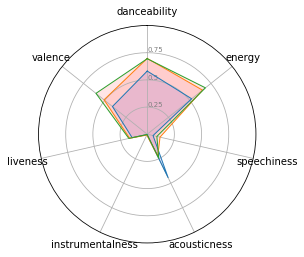

In [56]:
# ------- PART 1: Create background
from math import pi

# number of variable
categories=list(a)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="grey", size=7)
plt.ylim(0,1)
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=a.loc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
values=a.loc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'r', alpha=0.1)

values=a.loc[2].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'r', alpha=0.1)

IndexError: list index out of range

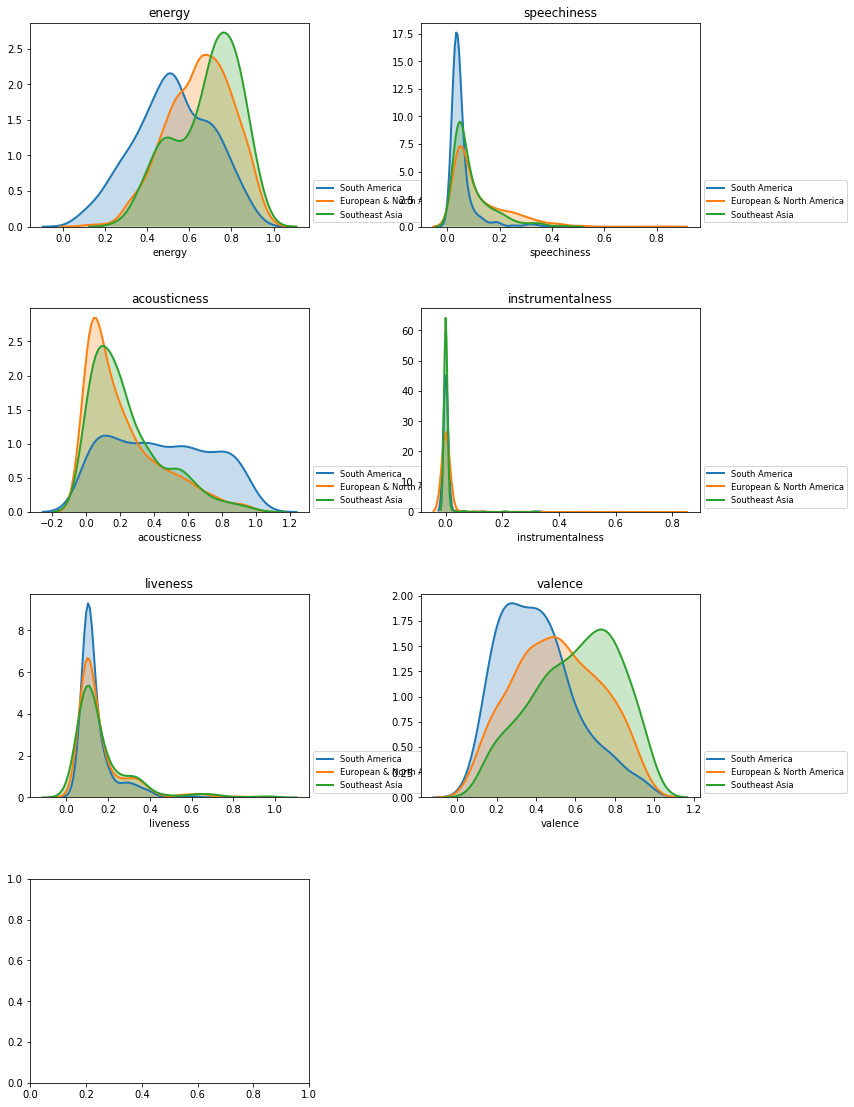

In [57]:
fig = plt.figure(figsize = (12,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 10):
    ax = fig.add_subplot(6, 2, i)
    l1=sns.distplot(group_0_audio.groupby('spotify_id').max()[hist_columns[i]], 
                    hist = False, kde = True, 
                    kde_kws = {'shade': True, 'linewidth': 2},label = cluster_regions[0])
    l2=sns.distplot(group_1_audio.groupby('spotify_id').max()[hist_columns[i]], 
                    hist = False, kde = True, 
                    kde_kws = {'shade': True, 'linewidth': 2},label = cluster_regions[1])
    l3=sns.distplot(group_2_audio.groupby('spotify_id').max()[hist_columns[i]], 
                    hist = False, kde = True, 
                    kde_kws = {'shade': True, 'linewidth': 2},label = cluster_regions[2])
    ax.set_title(hist_columns[i])
    ax.legend(fontsize = 'small', loc = 'lower left', bbox_to_anchor=(1, 0))

plt.show()

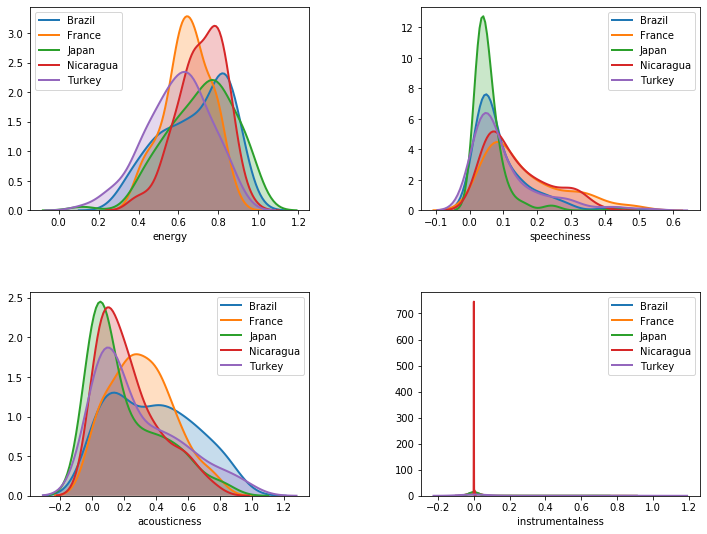

In [58]:
fig = plt.figure(figsize = (12,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 5):
    ax = fig.add_subplot(6, 2, i)   
    for country in unique_country:
        data = unique_country_audio[unique_country_audio['Country'] == country]
        sns.distplot(data.groupby('spotify_id').max()[hist_columns[i]], 
                     hist = False, kde = True, bins = 20,
                     kde_kws = {'shade': True, 'linewidth': 2},label = country)
plt.legend()
plt.show()

IndexError: list index out of range

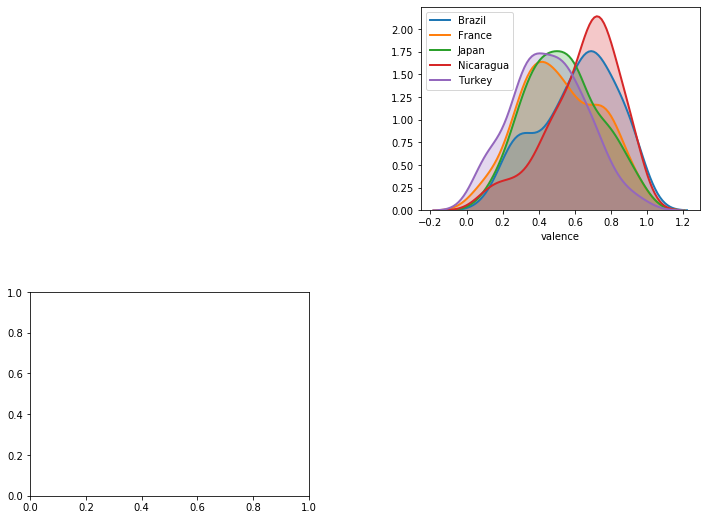

In [59]:
fig = plt.figure(figsize = (12,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(6, 10):
    ax = fig.add_subplot(6, 2, i)   
    for country in unique_country:
        data = unique_country_audio[unique_country_audio['Country'] == country]
        sns.distplot(data.groupby('spotify_id').max()[hist_columns[i]], 
                     hist = False, kde = True, bins = 20,
                     kde_kws = {'shade': True, 'linewidth': 2},label = country)
plt.legend()
plt.show()

In [ ]:
plt.bar(group_0_audio['key'].value_counts().index, group_0_audio['key'].value_counts())
plt.bar(group_1_audio['key'].value_counts().index, group_1_audio['key'].value_counts(), alpha = 0.5)
plt.show()


In [ ]:
group_1_audio['key'].value_counts()

In [ ]:
group_2_audio['key'].value_counts()

## Lyrics Analysis

In [ ]:
lyrics = pd.read_csv('lyrics.csv')

In [ ]:
lyrics.head()

In [ ]:
len(lyrics)

In [ ]:
# preprocessing text
import spacy
nlp = spacy.load('en', disable=['ner'], max_length = 1000000000)

In [ ]:
corpus = [nlp(text) for text in list(lyrics['lyrics'])]

In [ ]:
# create tokenized text
corpus_tokens, verbs, nouns, adverbs = [],[],[],[]
 
for doc in corpus:
    tokens,verb, noun, adverb = [],[],[],[]
    for token in doc:
        if token.lemma_ == "-PRON-":
            lemma = token.text
        else:
            lemma = token.lemma_
        
        if token.pos_ == r'VERB':
            verb.append(lemma)
        elif token.pos_ == r'NOUN':
            noun.append(lemma)
        elif token.pos_ == 'ADV':
            adverb.append(lemma)
        
        tokens.append(lemma)
            
    verbs.append(verb)
    nouns.append(noun)
    adverbs.append(adverb)
    corpus_tokens.append(tokens)
            

In [ ]:
lyrics['token'] = corpus_tokens
lyrics['nouns'] = nouns
lyrics['verbs'] = verbs
lyrics['adverbs'] = adverbs

In [ ]:
lyrics.head(3)

In [ ]:
group_0_lyrics = pd.merge(group_0, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')
group_1_lyrics = pd.merge(group_1, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')
group_2_lyrics = pd.merge(group_2, lyrics[['spotify_id','token','nouns','verbs','adverbs']], 
                          how = 'left', left_on = 'spotify_id', right_on = 'spotify_id')

In [ ]:
group_0_lyrics.head()

In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add('PRON')
spacy_stopwords.add('oh')
spacy_stopwords.add('yeah')
spacy_stopwords.add('que')
spacy_stopwords.add('che')
spacy_stopwords.add('la')
spacy_stopwords.add('el')
spacy_stopwords.add('eh')
spacy_stopwords.add('ooh')
spacy_stopwords.add('doo')
spacy_stopwords.add('en')
spacy_stopwords.add('na')
spacy_stopwords.add('yo')
spacy_stopwords.add('chorus')
spacy_stopwords.add('pre')
spacy_stopwords.add('li')
spacy_stopwords.add('di')
spacy_stopwords.add('un')
spacy_stopwords.add('yeh')
spacy_stopwords.add('verse')
spacy_stopwords.add('il')
spacy_stopwords.add('non')
spacy_stopwords.add('mi')
spacy_stopwords.add('uh')
spacy_stopwords.add('ma')
spacy_stopwords.add('da')
spacy_stopwords.add('de')
spacy_stopwords.add('like')
spacy_stopwords.add('hol')
spacy_stopwords.add('doo')
spacy_stopwords.add('thunder')

In [ ]:
def wordcloud(text, max_words):
    wordcloud = WordCloud(width = 4000,
                          height = 3000,
                          background_color="white",
                          stopwords = spacy_stopwords,
                          max_words = max_words).generate(text)
    plt.figure(figsize=(40,25))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return

In [ ]:
group_0_nouns = [word for sublist in list(group_0_lyrics['nouns']) for word in sublist]
group_0_nouns = ' '.join(group_0_nouns)

In [ ]:
wordcloud(group_0_nouns, 400)

In [ ]:
group_1_nouns = [word for sublist in list(group_1_lyrics['nouns']) for word in sublist]
group_1_nouns = ' '.join(group_1_nouns)

In [ ]:
wordcloud(group_1_nouns,400)

In [ ]:
group_2_nouns = [word for sublist in list(group_2_lyrics['nouns']) for word in sublist]
group_2_nouns = ' '.join(group_2_nouns)
wordcloud(group_2_nouns, 400)

In [ ]:
group_0_adverbs = [word for sublist in list(group_0_lyrics['adverbs']) for word in sublist]
group_0_adverbs = ' '.join(group_0_adverbs)
wordcloud(group_0_adverbs, 400)

In [ ]:
group_1_adverbs = [word for sublist in list(group_1_lyrics['adverbs']) for word in sublist]
group_1_adverbs = ' '.join(group_1_adverbs)
wordcloud(group_1_adverbs, 400)

In [ ]:
group_2_adverbs = [word for sublist in list(group_2_lyrics['adverbs']) for word in sublist]
group_2_adverbs = ' '.join(group_2_adverbs)
wordcloud(group_2_adverbs, 400)

## Top Artists

The following analysis analyze the top artists around the world as well as in specific areas.

create a dataframe that countains top 50 artists who is popular in the country the frequency of an artist who is on the list

Frequency/Popularity definition: if one artist appeared once in the top 200 songs in a country in a given week, increment the popularity by 1

In [42]:
df_artist = pd.DataFrame()
for country in countries:
    file_name = 'total_rank_data/' + country[0] + '.csv'
    temp = pd.read_csv(file_name)
    famous_song_series = temp[['Artist', 'spotify_id']]
    famous_song_df = pd.DataFrame({'Artist': famous_song_series['Artist'],
                                   'spotify_id': famous_song_series['spotify_id'],
                                   'Country': country[1]})
    famous_artist = famous_song_df['Artist'].value_counts()[:50]
    famous_artist_df = pd.DataFrame({'Artist': famous_artist.index, "Frequency": famous_artist.values, "Country": country[1]})
    df_artist = df_artist.append(famous_artist_df)
df_artist

,Artist,Frequency,Country
0,Ozuna,45,Argentina
1,Duki,41,Argentina
2,Ed Sheeran,36,Argentina
3,Ariana Grande,31,Argentina
4,BTS,31,Argentina
...,...,...,...
45,Imagine Dragons,6,Vietnam
46,5 Seconds of Summer,6,Vietnam
47,Bebe Rexha,6,Vietnam
48,Lady Gaga,6,Vietnam


Add up the all the frequency in individual country to create global popularity

In [45]:
df_global_fame = df_artist[["Artist", "Frequency"]].groupby("Artist").agg('sum').sort_values('Frequency', ascending=False)
df_global = pd.DataFrame({"Artist": df_global_fame.index, "Global Popularity": df_global_fame["Frequency"]})
df_global = df_global.reset_index(drop=True)
df_global[:20]

,Artist,Global Popularity
0,Drake,2049
1,Ed Sheeran,2017
2,Ariana Grande,1881
3,Post Malone,1585
4,BTS,1451
5,The Chainsmokers,1280
6,XXXTENTACION,1275
7,Linkin Park,1114
8,Eminem,1030
9,Taylor Swift,986


Based on cluster result, create popularity dataframe by cluster

In [46]:
df_cluster_1 = pd.DataFrame()
df_cluster_2 = pd.DataFrame()
df_cluster_3 = pd.DataFrame()
for index, row in df_artist.iterrows():
    if row['Country'] in cluster_1:
        df_cluster_1 = df_cluster_1.append(row)
    elif row['Country'] in cluster_2:
        df_cluster_2 = df_cluster_2.append(row)
    elif row['Country'] in cluster_3:
        df_cluster_3 = df_cluster_3.append(row)

Analyze cluster 1 which is the eroupe, NA, Oceania cluster

In [47]:
df_Euro_fame = df_cluster_1[["Artist", "Frequency"]].groupby("Artist").agg('sum').sort_values('Frequency', ascending=False)
df_Euro = pd.DataFrame({"Artist": df_Euro_fame.index, "Europe Popularity": df_Euro_fame["Frequency"]})
df_Euro = df_Euro.reset_index(drop=True)
df_Euro[:20]

,Artist,Europe Popularity
0,Drake,1376.0
1,Ed Sheeran,1181.0
2,Post Malone,1099.0
3,XXXTENTACION,1039.0
4,Ariana Grande,1012.0
5,Eminem,897.0
6,The Chainsmokers,794.0
7,Linkin Park,604.0
8,Travis Scott,593.0
9,Billie Eilish,575.0


Analyze cluster 2 which is the SA cluster

In [48]:
df_SA_fame = df_cluster_2[["Artist", "Frequency"]].groupby("Artist").agg('sum').sort_values('Frequency', ascending=False)
df_SA = pd.DataFrame({"Artist": df_SA_fame.index, "South America Popularity": df_SA_fame["Frequency"]})
df_SA = df_SA.reset_index(drop=True)
df_SA[:20]

,Artist,South America Popularity
0,Ozuna,766.0
1,Bad Bunny,492.0
2,J Balvin,456.0
3,Ariana Grande,453.0
4,Ed Sheeran,438.0
5,BTS,435.0
6,Maluma,381.0
7,Drake,375.0
8,Paulo Londra,332.0
9,Sebastian Yatra,282.0


Analyze cluster 3 which is the Asia cluster

In [49]:
df_Asia_fame = df_cluster_3[["Artist", "Frequency"]].groupby("Artist").agg('sum').sort_values('Frequency', ascending=False)
df_Asia = pd.DataFrame({"Artist": df_Asia_fame.index, "Asia Popularity": df_Asia_fame["Frequency"]})
df_Asia = df_Asia.reset_index(drop=True)
df_Asia[:20]

,Artist,Asia Popularity
0,BTS,427.0
1,Ariana Grande,285.0
2,Ed Sheeran,273.0
3,The Chainsmokers,251.0
4,Linkin Park,248.0
5,Taylor Swift,245.0
6,Post Malone,185.0
7,Drake,174.0
8,Camila Cabello,158.0
9,BLACKPINK,158.0


Develop a big table containing each composition of popularity accross areas

In [50]:
df_percentile = df_global.merge(df_Euro, on="Artist", how="left")
df_percentile = df_percentile.merge(df_SA, on="Artist", how="left")
df_percentile = df_percentile.merge(df_Asia, on="Artist", how="left")
df_percentile = df_percentile.fillna(0)

Create percentile representation of artists popularity breakdown by areas

In [51]:
df_percentile['Europe Percent'] = round(df_percentile["Europe Popularity"]\
                                        / df_percentile["Global Popularity"], 4)
df_percentile['SA Percent'] = round(df_percentile["South America Popularity"] / df_percentile["Global Popularity"], 4)
df_percentile['Asia Percent'] = round(df_percentile["Asia Popularity"] / df_percentile["Global Popularity"], 4)
df_percentile['Other Percent'] = round((df_percentile["Global Popularity"]\
                                        -df_percentile["Europe Popularity"]\
                                        -df_percentile["South America Popularity"]\
                                        -df_percentile["Asia Popularity"])\
                                        / df_percentile["Global Popularity"], 4)
df_percentile[:10]

,Artist,Global Popularity,Europe Popularity,South America Popularity,Asia Popularity,Europe Percent,SA Percent,Asia Percent,Other Percent
0,Drake,2049,1376.0,375.0,174.0,0.6715,0.1830,0.0849,0.0605
1,Ed Sheeran,2017,1181.0,438.0,273.0,0.5855,0.2172,0.1353,0.0620
2,Ariana Grande,1881,1012.0,453.0,285.0,0.5380,0.2408,0.1515,0.0696
3,Post Malone,1585,1099.0,221.0,185.0,0.6934,0.1394,0.1167,0.0505
4,BTS,1451,469.0,435.0,427.0,0.3232,0.2998,0.2943,0.0827
5,The Chainsmokers,1280,794.0,164.0,251.0,0.6203,0.1281,0.1961,0.0555
6,XXXTENTACION,1275,1039.0,147.0,42.0,0.8149,0.1153,0.0329,0.0369
7,Linkin Park,1114,604.0,194.0,248.0,0.5422,0.1741,0.2226,0.0610
8,Eminem,1030,897.0,9.0,65.0,0.8709,0.0087,0.0631,0.0573
9,Taylor Swift,986,504.0,168.0,245.0,0.5112,0.1704,0.2485,0.0700


Create a list of pairs that marks different level of popularity with corresponding number of artists

In [52]:
# divide intervals to count the number of artists in the interval
ranges = [0,30,80,200,500,1000,2000,2500]
popularity_chart = df_percentile["Artist"].groupby(pd.cut(df_percentile["Global Popularity"], ranges)).count()
temp_array = list(popularity_chart.values)
# reverse the array to do addition
temp_array = temp_array[::-1]
for i in range(1, len(temp_array)):
    temp_array[i] = temp_array[i] + temp_array[i-1]
# construct pairs of popularity & number of singers
popularity_fact = list(zip(temp_array, ranges[:-1][::-1]))[:-1]
popularity_fact

[(2, 2000), (9, 1000), (22, 500), (54, 200), (122, 80), (281, 30)]

Plot the popularity vs the number of the artists in the category

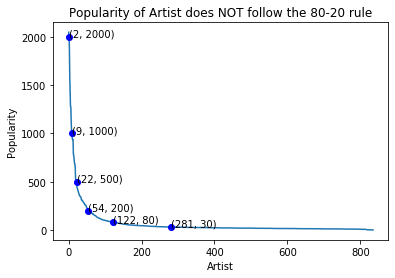

In [53]:
plt.plot(df_percentile["Global Popularity"])
for item in popularity_fact:
    plt.plot(item[0], item[1], 'bo')
    plt.annotate("(" + str(item[0]) + ", " + str(item[1]) + ")", (item[0], item[1]))
plt.ylabel('Popularity')
plt.xlabel('Artist')
plt.title("Popularity of Artist does NOT follow the 80-20 rule")
plt.show()

This plot shows the sharp decrease in popularity as the number of artist increases, indicating the popularity of artists does not follow the 80 20 rule. There are a few top and most telented artists in the market with a lot of average artists who has far less popularity. 

In [55]:
df_graph = df_percentile[["Artist", "Global Popularity", "Europe Percent", "SA Percent", "Asia Percent", 'Other Percent']]
df_graph

,Artist,Global Popularity,Europe Percent,SA Percent,Asia Percent,Other Percent
0,Drake,2049,0.6715,0.1830,0.0849,0.0605
1,Ed Sheeran,2017,0.5855,0.2172,0.1353,0.0620
2,Ariana Grande,1881,0.5380,0.2408,0.1515,0.0696
3,Post Malone,1585,0.6934,0.1394,0.1167,0.0505
4,BTS,1451,0.3232,0.2998,0.2943,0.0827
...,...,...,...,...,...,...
831,JP Cooper,1,1.0000,0.0000,0.0000,0.0000
832,Cheat Codes,1,1.0000,0.0000,0.0000,0.0000
833,Louis Tomlinson,1,1.0000,0.0000,0.0000,0.0000
834,Sigala,1,1.0000,0.0000,0.0000,0.0000


Select some sample artists and draw pie graphs to visualize their influence by area

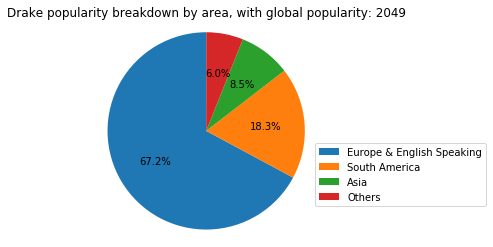

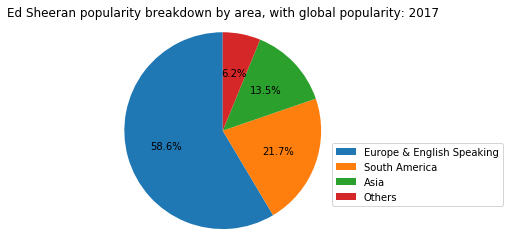

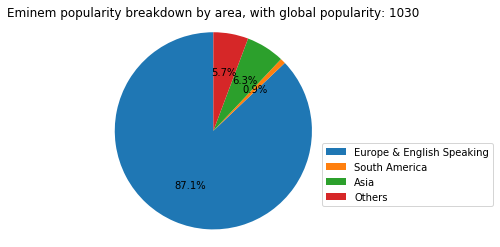

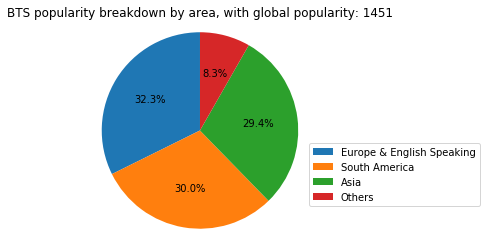

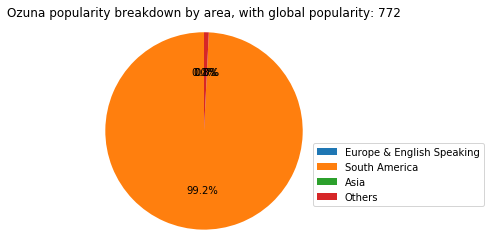

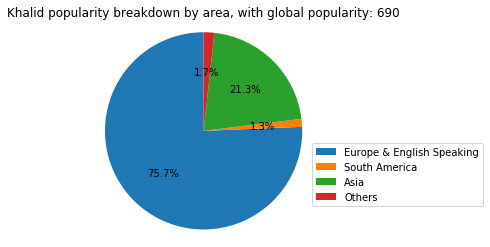

In [56]:
singers = ['Drake', 'Ed Sheeran', 'Eminem', 'BTS', 'Ozuna', 'Khalid']
labels = ["Europe & English Speaking", "South America", "Asia", "Others"]
for singer in singers:
    array = np.array(df_graph[df_graph['Artist'] == singer])
    ploting = array[0][2:]
    plt.pie(ploting, autopct='%1.1f%%', startangle=90)
    plt.title(array[0][0] + " popularity breakdown by area, with global popularity: " + str(array[0][1]))
    plt.legend(labels, loc="right", bbox_to_anchor=(1.35, 0.3))
    plt.axis('equal') 
    plt.show()

This visualzation shows that even the most popular artists, there is significant difference in their influence in individual areas

In [57]:
df_percentile["Other Popularity"] = df_percentile["Global Popularity"]\
                                    - df_percentile["Europe Popularity"]\
                                    - df_percentile["South America Popularity"]\
                                    - df_percentile["Asia Popularity"]
df_percentile[:10]

,Artist,Global Popularity,Europe Popularity,South America Popularity,Asia Popularity,Europe Percent,SA Percent,Asia Percent,Other Percent,Other Popularity
0,Drake,2049,1376.0,375.0,174.0,0.6715,0.1830,0.0849,0.0605,124.0
1,Ed Sheeran,2017,1181.0,438.0,273.0,0.5855,0.2172,0.1353,0.0620,125.0
2,Ariana Grande,1881,1012.0,453.0,285.0,0.5380,0.2408,0.1515,0.0696,131.0
3,Post Malone,1585,1099.0,221.0,185.0,0.6934,0.1394,0.1167,0.0505,80.0
4,BTS,1451,469.0,435.0,427.0,0.3232,0.2998,0.2943,0.0827,120.0
5,The Chainsmokers,1280,794.0,164.0,251.0,0.6203,0.1281,0.1961,0.0555,71.0
6,XXXTENTACION,1275,1039.0,147.0,42.0,0.8149,0.1153,0.0329,0.0369,47.0
7,Linkin Park,1114,604.0,194.0,248.0,0.5422,0.1741,0.2226,0.0610,68.0
8,Eminem,1030,897.0,9.0,65.0,0.8709,0.0087,0.0631,0.0573,59.0
9,Taylor Swift,986,504.0,168.0,245.0,0.5112,0.1704,0.2485,0.0700,69.0


Visualize the top 15 artists and their population breakdown in geographical areas

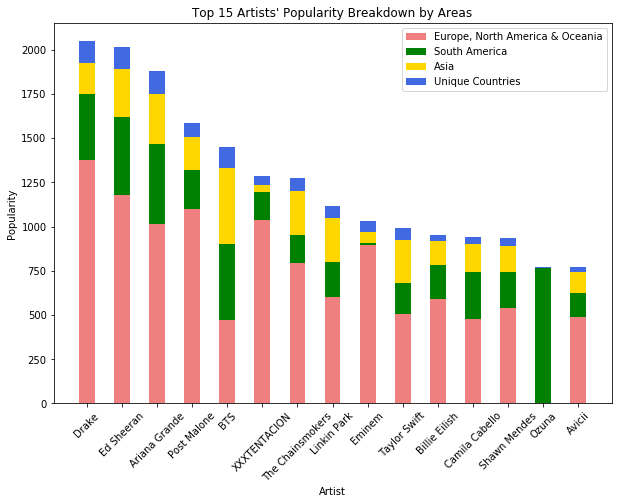

In [76]:
plt.figure(figsize=(10,7))
N = 15
Europe = df_percentile["Europe Popularity"][:15]
SA =  df_percentile["South America Popularity"][:15]
Asia = df_percentile["Asia Popularity"][:15]
Other =  df_percentile["Other Popularity"][:15]
ind = np.arange(N)    # the x locations for the groups
width = 0.45       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, Europe, width, label="Europe, North America & Oceania", color='lightcoral')
p2 = plt.bar(ind, SA, width, bottom=Europe, label="South America", color='green')
p3 = plt.bar(ind, Asia, width, bottom=Europe+SA, label="Asia", color='gold')
p4 = plt.bar(ind, Other, width, bottom=Europe+SA+Asia, label="Unique Countries", color='royalblue')

plt.ylabel('Popularity')
plt.xlabel('Artist')
plt.title("Top 15 Artists' Popularity Breakdown by Areas")
plt.xticks(ind, df_percentile["Artist"][:15], rotation=45)
plt.legend(prop={'size': 10})

From this graph we could also observe the difference in artists influence in individual area. The height of the graph give reader more sence about the global popularity of the artists.